<a href="https://colab.research.google.com/github/ferdinand-lanvino/commodity-predictor/blob/master/commodity_price_predictor_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Setup** <a name="setup"></a>

Clone the dataset

In [1]:
# Clone commodity-predictor repo.
!git clone -l -s git://github.com/ferdinand-lanvino/commodity-predictor.git
%cd commodity-predictor
!ls

Cloning into 'commodity-predictor'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 141 (delta 55), reused 62 (delta 16), pack-reused 0
Receiving objects: 100% (141/141), 1.74 MiB | 12.46 MiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/commodity-predictor
commodity_predictor_research.ipynb  Dataset
commodity-price-predictor.ipynb     README.md


In [8]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 9

In [3]:
# pd.set_option('display.max_rows', 2000)
#Importing dataset 
dataset = pd.read_csv('Dataset/Converted/commodity.csv')
dataset['tanggal'] = pd.to_datetime(dataset['tanggal'],format='%d/%m/%Y')
#Drop all NaN values
dataset = dataset.dropna(how='any',axis=0)
print(dataset)

              komoditas    tanggal    harga
0                 Beras 2016-07-25  10900.0
1                 Beras 2016-07-26  10950.0
2                 Beras 2016-07-27  10950.0
3                 Beras 2016-07-28  10950.0
4                 Beras 2016-07-29  10950.0
...                 ...        ...      ...
29327  Gula Pasir Lokal 2020-05-20  17500.0
29328  Gula Pasir Lokal 2020-05-26  17650.0
29329  Gula Pasir Lokal 2020-05-27  17650.0
29330  Gula Pasir Lokal 2020-05-28  17650.0
29331  Gula Pasir Lokal 2020-05-29  17650.0

[29242 rows x 3 columns]


In [4]:
dataset.describe()

,harga
count,29242.000000
mean,36336.729704
std,36899.133797
min,9000.000000
25%,12850.000000
50%,24000.000000
75%,39000.000000
max,160000.000000


In [5]:
def get_insight(commodity_name,dataset):
  print("-----------------------------------")

  #Get sub dataset per commodity type
  subdataset = dataset[dataset.komoditas==commodity_name]
  #Set index by tanggal (date)
  subdataset = subdataset[['tanggal','harga']].set_index('tanggal')
  #reindex
  subdataset.index = pd.DatetimeIndex(subdataset.index)
  return subdataset

-----------------------------------


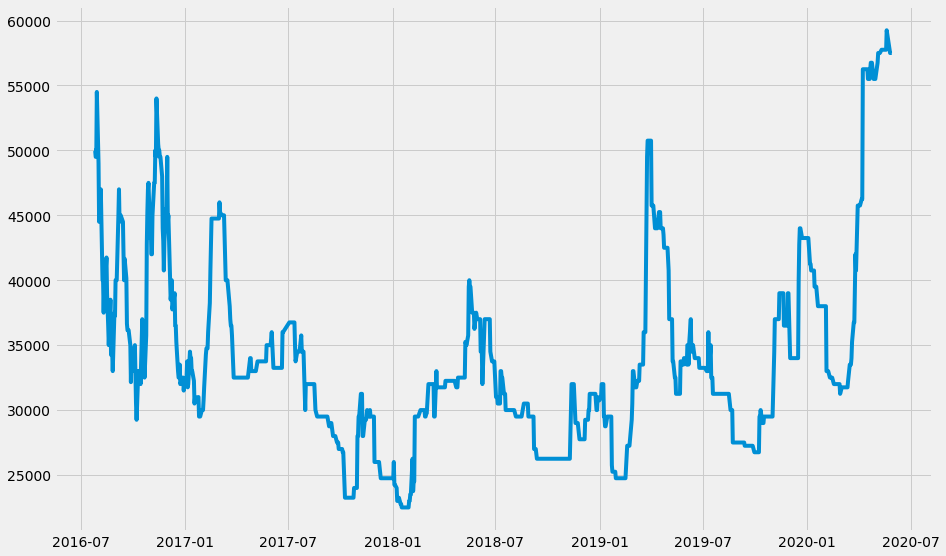

In [9]:
subdataset_commodity = "Bawang Merah"
subdataset_raw = get_insight(subdataset_commodity,dataset)
plt.plot(subdataset_raw['harga'])

In [11]:
def imputating(commodity_name,dataset):
  print("-----------------------------------")
  print("Imputing "+commodity_name)

  #Get sub dataset per commodity type
  subdataset = dataset[dataset.komoditas==commodity_name]
  #Set index by tanggal (date)
  subdataset = subdataset[['tanggal','harga']].set_index('tanggal')
  #reindex
  subdataset.index = pd.DatetimeIndex(subdataset.index)

  subdataset_imputed = subdataset.asfreq('D')
  #filling NaN values with LOCF (Last Observation Carried Forward) algorithm using method Forward Fill
  subdataset_imputed['harga-imputed'] = subdataset.asfreq('D', method='ffill')
  plt.plot(subdataset_imputed)
  plt.title(commodity_name)
  plt.xlabel('Tanggal (Harian)')
  plt.ylabel('Harga (Kg)')
  subdataset_imputed = subdataset_imputed.drop(['harga'], axis = 1) 
  print(subdataset_imputed.info())
  return subdataset_imputed

-----------------------------------
Imputing Bawang Merah
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1405 entries, 2016-07-25 to 2020-05-29
Freq: D
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   harga-imputed  1405 non-null   float64
dtypes: float64(1)
memory usage: 22.0 KB
None


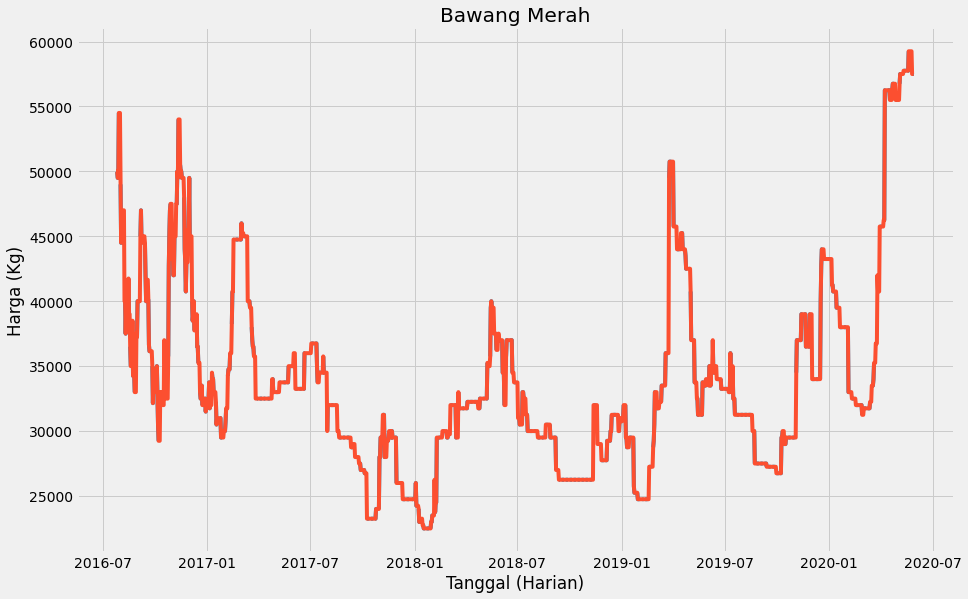

In [12]:
subdataset = imputating(subdataset_commodity,dataset)

In [14]:
subdataset

,harga-imputed
tanggal,
2016-07-25,50000.0
2016-07-26,50000.0
2016-07-27,49500.0
2016-07-28,49500.0
2016-07-29,54500.0
...,...
2020-05-25,59250.0
2020-05-26,57500.0
2020-05-27,57500.0


In [16]:
#Converting the dataframe to a numpy array
dataset = subdataset.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(subdataset) *.8) 

In [17]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [18]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [19]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [20]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [21]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [35]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [59]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)


Epoch 1/1
1064/1064 [==============================] - 46s 44ms/step - loss: 0.0014


In [60]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [61]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [62]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [63]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [65]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

1120.9511410031214

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


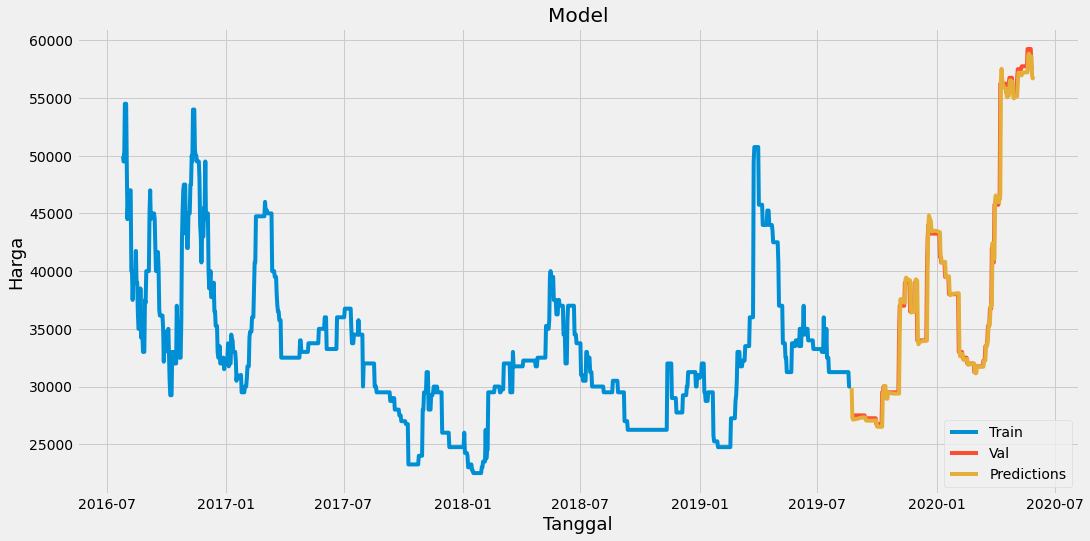

In [66]:
#Plot/Create the data for the graph
train = subdataset[:training_data_len]
valid = subdataset[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Tanggal', fontsize=18)
plt.ylabel('Harga', fontsize=18)
plt.plot(train['harga-imputed'])
plt.plot(valid[['harga-imputed', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [58]:
valid

,harga-imputed,Predictions
tanggal,,
2019-08-23,27500.0,29677.373047
2019-08-24,27500.0,27275.667969
2019-08-25,27500.0,27099.232422
2019-08-26,27500.0,27105.949219
2019-08-27,27500.0,27086.285156
...,...,...
2020-05-25,59250.0,58014.832031
2020-05-26,57500.0,57989.355469
2020-05-27,57500.0,56349.679688


In [55]:
#Create a new dataframe
new_df = subdataset
#Get teh last 60 day closing price 
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[56378.25]]
